# Projet de modélisation d'un mix énergétique issu 100% d'ENR

## X. Modelling new production profils

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
import plotly.graph_objects as go

In [2]:
from typical_days import Profils_vre_datetime, Mean_std_profil_18, Array_mean_std, New_Array_mean_std, Clustering_days, Index_centers, Typical_days, Typical_year, Labels_new_year, Typical_new_year, distanceMetric, ans, Import_data
from modelling_new_year import Decomposition, Simulate_Noise

profils_off, profils_on, profils_pv = Profils_vre_datetime()

### Choice of one year among the 18

In [3]:
year = np.random.randint(0,18,1)
print("Année : ", ans[year[0]])

Année :  2001


### Tecnology used

In [50]:
vre = 'offshore'

if vre == 'pv':
    profils = profils_pv
elif vre == 'onshore':
    profils = profils_on
else:
    profils = profils_off

In [51]:
day_mean_18, p18 = Mean_std_profil_18(profils)
day_std_18, _ = Mean_std_profil_18(profils, False)

## Modelling new trend

### Daily mean

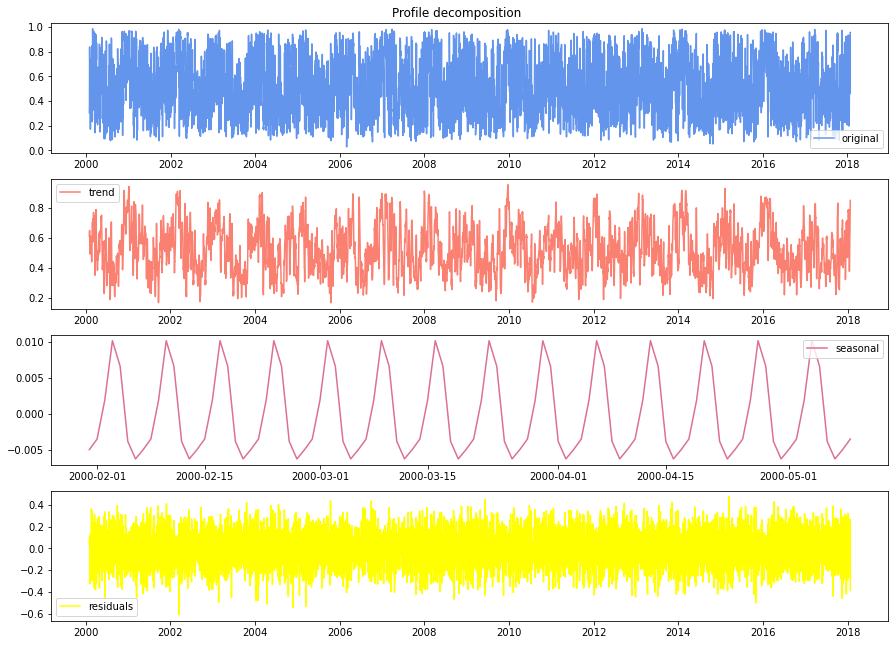

In [52]:
trend_mean, seasonal_mean, residual_mean = Decomposition(day_mean_18)

In [53]:
new_mean = Simulate_Noise(trend_mean, seasonal_mean, residual_mean, day_mean_18)

ecart type du bruit :  0.16310637100836356
moyenne du bruit :  -1.5059869361779234e-05


### Daily standard deviation

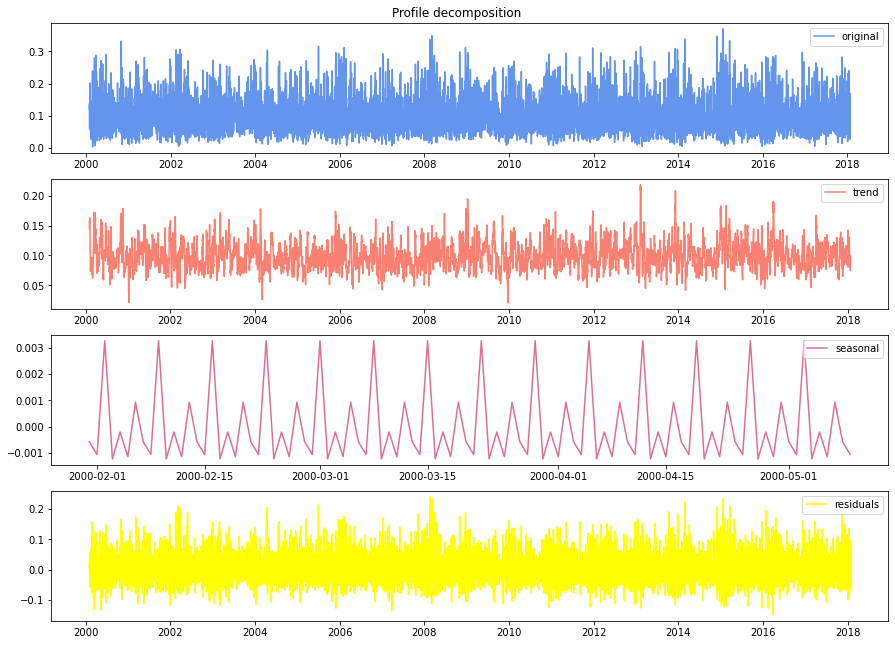

In [54]:
trend_std, seasonal_std, residual_std = Decomposition(day_std_18)

In [55]:
new_std = Simulate_Noise(trend_std, seasonal_std, residual_std, day_std_18)

ecart type du bruit :  0.049959835234369886
moyenne du bruit :  1.4503430991525844e-05


#### Nouveaux profils annuels de moyenne et variance journalières

In [56]:
new_daily_mean = new_mean[365*year[0]:365*(year[0]+1)]
new_daily_std = new_std[365*year[0]:365*(year[0]+1)]
new_array = New_Array_mean_std(new_daily_mean, new_daily_std)

## Typical days clustering

Creation des clusters avec un représentant du groupe de jours aux mêmes caractéristiques (variance et moyenne)

#### Profils de production, de moyenne et de variance sur 18 ans

In [57]:
array = Array_mean_std(day_mean_18, day_std_18)

### KMedoids clustering

In [58]:
n_clusters = 12

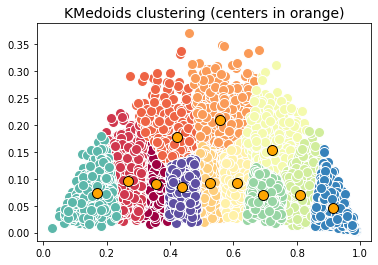

In [59]:
centers_existing_data, labels_existing_data = Clustering_days(array, n_clusters, verbose_plot = True)

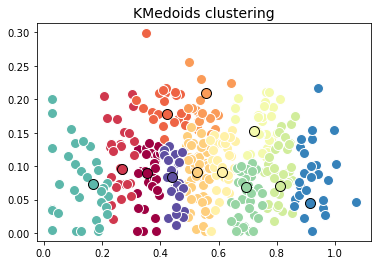

In [60]:
centers, labels, new_labels = Labels_new_year(array, new_array, n_clusters)

#### Typical days the from existing data

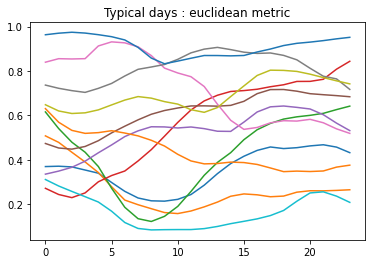

In [61]:
typical_days = Typical_days(n_clusters, centers, labels, array, p18)

plt.plot(typical_days)
plt.title("Typical days : euclidean metric")
plt.show()

#### Typical year with modelling trend (daily means)

In [62]:
typical_year = Typical_new_year(n_clusters, centers, labels, new_labels, array, p18)

In [63]:
an = 6

fig = go.Figure()
fig.add_trace(go.Scatter(y=np.array(profils[ans[an]]), name='profil année ' + ans[an]))
fig.add_trace(go.Scatter(y=typical_year, name='typical year'))
fig.update_layout(title="Comparison typical year vs 2006", yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [64]:
if vre == 'onshore':
    typical_year_on = pd.DataFrame(typical_year)
elif vre == 'offshore':
    typical_year_off = pd.DataFrame(typical_year)
else:
    typical_year_pv = pd.DataFrame(typical_year)

### After running the simulation for 3 technologies

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=typical_year_on[0], name='typical year on'))
fig.add_trace(go.Scatter(y=typical_year_off[0], name='typical year off'))
fig.add_trace(go.Scatter(y=typical_year_pv[0], name='typical year pv'))
fig.update_layout(title="Affichage des nouveaux profils pour les trois technologies", yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

#### Save new profil

In [71]:
vre2006 = pd.read_csv("inputs/vre_profiles2006.csv", header=None)
vrenew = pd.DataFrame()
vrenew = vre2006.copy()

typical_year_pv = pd.DataFrame(typical_year_pv)
typical_year_on = pd.DataFrame(typical_year_on)
typical_year_off = pd.DataFrame(typical_year_off)

vrenew[2].iloc[:8760] = typical_year_off[0]
vrenew[2].iloc[8760:17520] = typical_year_on[0]
vrenew[2].iloc[17520:] = typical_year_pv[0]
display(vrenew)
vrenew.to_csv('inputs/vrenew_typical_days_new_trend_2014.csv', header=None, index=False)

C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0     1         2
0      offshore     0  0.335714
1      offshore     1  0.349429
2      offshore     2  0.366571
3      offshore     3  0.394143
4      offshore     4  0.431857
...         ...   ...       ...
26275        pv  8755  0.000000
26276        pv  8756  0.000000
26277        pv  8757  0.000000
26278        pv  8758  0.000000
26279        pv  8759  0.000000

[26280 rows x 3 columns]

In [66]:
# Moyenne de chaque heure de la journée sur un an
# Vecteur de 24 (nb d'heures)

def Moyenne_jour(profil):
    heures, jours = np.shape(profil)
    moy_j = np.zeros(heures)
    for j in range(jours):
        for h in range(heures):
            moy_j[h] += profil[h,j]
    moy_j = moy_j/jours
    return moy_j

def Profils_journaliers(profil, vre, annee, verbose=False):
    if vre=="offshore":
        n=0
    elif vre=="onshore":
        n=8760
    elif vre=="pv":
        n=17519
        
    profil_jour = np.zeros((24,365))
    for j in range(365):
        for i in range(24):
            profil_jour[i,j] += [profil[2][(i+1)+j*24+n]]
            
    moy_jour = Moyenne_jour(profil_jour)
    plt.plot(moy_jour, label=annee)
    plt.title("Profil journalier de la production : " + vre)
    plt.xlabel("Heures")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    if verbose :
        return profil_jour

In [67]:
vre2000,vre2001,vre2002,vre2003,vre2004,vre2005,vre2006,vre2007,vre2008,vre2009,vre2010,vre2011,vre2012,vre2013,vre2014,vre2015,vre2016,vre2017 = Import_data()

In [68]:
vrenew_typical_days_new_trend_2006 = pd.read_csv('inputs/vrenew_typical_days_new_trend_2006.csv', header=None)
vrenew_typical_days_new_trend_2011 = pd.read_csv('inputs/vrenew_typical_days_new_trend_2011.csv', header=None)
vrenew_typical_days_new_trend_2014 = pd.read_csv('inputs/vrenew_typical_days_new_trend_2014.csv', header=None)

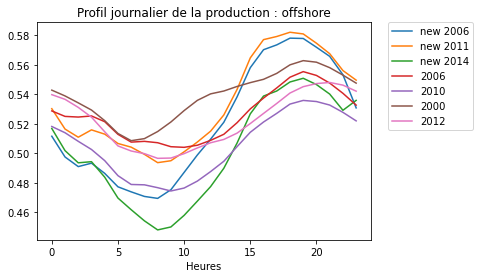

In [69]:
vre = "offshore"
Profils_journaliers(vrenew_typical_days_new_trend_2006, vre, "new 2006", verbose=False)
Profils_journaliers(vrenew_typical_days_new_trend_2011, vre, "new 2011", verbose=False)
Profils_journaliers(vrenew_typical_days_new_trend_2014, vre, "new 2014", verbose=False)
Profils_journaliers(vre2006, vre, "2006", verbose=False)
Profils_journaliers(vre2010, vre, "2010", verbose=False)
Profils_journaliers(vre2000, vre, "2000", verbose=False)
Profils_journaliers(vre2012, vre, "2012", verbose=False)
plt.show()